<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:13:11] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


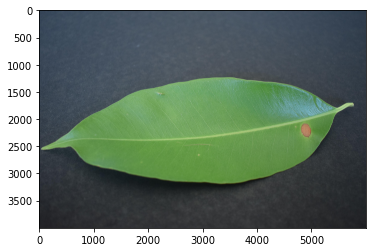

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

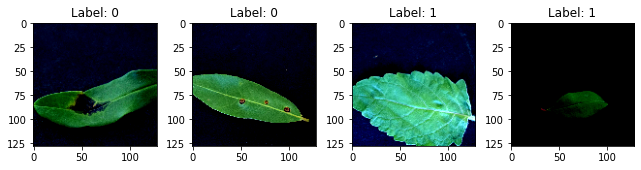

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:13:19] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:13:20] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2812822402301864 samples/sec                   batch loss = 0.9515921473503113 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2926739684302524 samples/sec                   batch loss = 0.8104158043861389 | accuracy = 0.4


Epoch[1] Batch[15] Speed: 1.2931131531507367 samples/sec                   batch loss = 0.28285980224609375 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.291557126552185 samples/sec                   batch loss = 0.711762547492981 | accuracy = 0.5


Epoch[1] Batch[25] Speed: 1.2888616119082303 samples/sec                   batch loss = 1.0318117141723633 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.2906901029646178 samples/sec                   batch loss = 0.7983770966529846 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.2869276239289515 samples/sec                   batch loss = 1.1196982860565186 | accuracy = 0.5


Epoch[1] Batch[40] Speed: 1.2998823326052114 samples/sec                   batch loss = 0.2642977237701416 | accuracy = 0.51875


Epoch[1] Batch[45] Speed: 1.2965672593044717 samples/sec                   batch loss = 1.2260618209838867 | accuracy = 0.5055555555555555


Epoch[1] Batch[50] Speed: 1.2959672354780079 samples/sec                   batch loss = 0.7140666246414185 | accuracy = 0.51


Epoch[1] Batch[55] Speed: 1.2915127833254814 samples/sec                   batch loss = 0.5351599454879761 | accuracy = 0.5136363636363637


Epoch[1] Batch[60] Speed: 1.2949228517018674 samples/sec                   batch loss = 0.6822740435600281 | accuracy = 0.5125


Epoch[1] Batch[65] Speed: 1.295728422155659 samples/sec                   batch loss = 0.6550157070159912 | accuracy = 0.5269230769230769


Epoch[1] Batch[70] Speed: 1.284189743499854 samples/sec                   batch loss = 0.9647404551506042 | accuracy = 0.5321428571428571


Epoch[1] Batch[75] Speed: 1.3009238402138397 samples/sec                   batch loss = 0.48173725605010986 | accuracy = 0.5433333333333333


Epoch[1] Batch[80] Speed: 1.2887192467898998 samples/sec                   batch loss = 0.4115082025527954 | accuracy = 0.55625


Epoch[1] Batch[85] Speed: 1.29541377540577 samples/sec                   batch loss = 0.2674209773540497 | accuracy = 0.5647058823529412


Epoch[1] Batch[90] Speed: 1.2922494147133685 samples/sec                   batch loss = 0.13386407494544983 | accuracy = 0.5833333333333334


Epoch[1] Batch[95] Speed: 1.2895473452707227 samples/sec                   batch loss = 1.0107886791229248 | accuracy = 0.5815789473684211


Epoch[1] Batch[100] Speed: 1.2939747535872494 samples/sec                   batch loss = 0.3091384470462799 | accuracy = 0.575


Epoch[1] Batch[105] Speed: 1.2979833357084645 samples/sec                   batch loss = 0.2283988893032074 | accuracy = 0.5833333333333334


Epoch[1] Batch[110] Speed: 1.2941143892297624 samples/sec                   batch loss = 0.9395549893379211 | accuracy = 0.5863636363636363


Epoch[1] Batch[115] Speed: 1.2949917185508322 samples/sec                   batch loss = 0.4539564251899719 | accuracy = 0.5978260869565217


Epoch[1] Batch[120] Speed: 1.2895629070618129 samples/sec                   batch loss = 0.3299160897731781 | accuracy = 0.59375


Epoch[1] Batch[125] Speed: 1.2899596117207741 samples/sec                   batch loss = 1.8760085105895996 | accuracy = 0.6


Epoch[1] Batch[130] Speed: 1.2893745057890456 samples/sec                   batch loss = 0.8589511513710022 | accuracy = 0.6038461538461538


Epoch[1] Batch[135] Speed: 1.289423161759846 samples/sec                   batch loss = 0.5366846919059753 | accuracy = 0.6129629629629629


Epoch[1] Batch[140] Speed: 1.2993193859720387 samples/sec                   batch loss = 0.6022878289222717 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.3028234648399055 samples/sec                   batch loss = 1.2003990411758423 | accuracy = 0.6086206896551725


Epoch[1] Batch[150] Speed: 1.3044452108964597 samples/sec                   batch loss = 0.6471710205078125 | accuracy = 0.6083333333333333


Epoch[1] Batch[155] Speed: 1.30067291144948 samples/sec                   batch loss = 0.4889114499092102 | accuracy = 0.6129032258064516


Epoch[1] Batch[160] Speed: 1.303462261030787 samples/sec                   batch loss = 2.012554883956909 | accuracy = 0.6125


Epoch[1] Batch[165] Speed: 1.2972580090558685 samples/sec                   batch loss = 0.8110063076019287 | accuracy = 0.6090909090909091


Epoch[1] Batch[170] Speed: 1.297972088814591 samples/sec                   batch loss = 0.44828081130981445 | accuracy = 0.6102941176470589


Epoch[1] Batch[175] Speed: 1.27635115401519 samples/sec                   batch loss = 0.48008134961128235 | accuracy = 0.6142857142857143


Epoch[1] Batch[180] Speed: 1.2725482258621523 samples/sec                   batch loss = 0.3583133816719055 | accuracy = 0.6194444444444445


Epoch[1] Batch[185] Speed: 1.2703147609704544 samples/sec                   batch loss = 0.4862389862537384 | accuracy = 0.6216216216216216


Epoch[1] Batch[190] Speed: 1.2726533475578599 samples/sec                   batch loss = 0.4679137170314789 | accuracy = 0.625


Epoch[1] Batch[195] Speed: 1.2718076537925942 samples/sec                   batch loss = 0.7299383282661438 | accuracy = 0.6256410256410256


Epoch[1] Batch[200] Speed: 1.2716307656858907 samples/sec                   batch loss = 0.4211007356643677 | accuracy = 0.6275


Epoch[1] Batch[205] Speed: 1.2675042447284455 samples/sec                   batch loss = 0.3739505410194397 | accuracy = 0.6329268292682927


Epoch[1] Batch[210] Speed: 1.2684582416327026 samples/sec                   batch loss = 0.3293648958206177 | accuracy = 0.6345238095238095


Epoch[1] Batch[215] Speed: 1.2615255306937307 samples/sec                   batch loss = 0.32957208156585693 | accuracy = 0.6395348837209303


Epoch[1] Batch[220] Speed: 1.2651039110715112 samples/sec                   batch loss = 0.37603771686553955 | accuracy = 0.6409090909090909


Epoch[1] Batch[225] Speed: 1.2600596937802206 samples/sec                   batch loss = 0.4723376929759979 | accuracy = 0.6433333333333333


Epoch[1] Batch[230] Speed: 1.2684780938763018 samples/sec                   batch loss = 0.39213883876800537 | accuracy = 0.6423913043478261


Epoch[1] Batch[235] Speed: 1.2676979945059823 samples/sec                   batch loss = 0.4834335446357727 | accuracy = 0.6425531914893617


Epoch[1] Batch[240] Speed: 1.2687082142524682 samples/sec                   batch loss = 0.5538732409477234 | accuracy = 0.6447916666666667


Epoch[1] Batch[245] Speed: 1.262090376002101 samples/sec                   batch loss = 1.350997805595398 | accuracy = 0.6448979591836734


Epoch[1] Batch[250] Speed: 1.264396560059646 samples/sec                   batch loss = 0.4206097424030304 | accuracy = 0.647


Epoch[1] Batch[255] Speed: 1.2669465990809412 samples/sec                   batch loss = 0.7529144883155823 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.263514125163482 samples/sec                   batch loss = 0.795819878578186 | accuracy = 0.6490384615384616


Epoch[1] Batch[265] Speed: 1.2665823748842298 samples/sec                   batch loss = 0.6871066093444824 | accuracy = 0.6443396226415095


Epoch[1] Batch[270] Speed: 1.278858733321864 samples/sec                   batch loss = 0.48332834243774414 | accuracy = 0.6462962962962963


Epoch[1] Batch[275] Speed: 1.2721103574320973 samples/sec                   batch loss = 0.38744238018989563 | accuracy = 0.6509090909090909


Epoch[1] Batch[280] Speed: 1.2666214845138133 samples/sec                   batch loss = 0.5275359153747559 | accuracy = 0.6535714285714286


Epoch[1] Batch[285] Speed: 1.2606563804682154 samples/sec                   batch loss = 0.5465942621231079 | accuracy = 0.6552631578947369


Epoch[1] Batch[290] Speed: 1.2700156030426084 samples/sec                   batch loss = 1.1372990608215332 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.265990765939831 samples/sec                   batch loss = 0.32937124371528625 | accuracy = 0.6610169491525424


Epoch[1] Batch[300] Speed: 1.2621002501073302 samples/sec                   batch loss = 0.7625290155410767 | accuracy = 0.6583333333333333


Epoch[1] Batch[305] Speed: 1.2587908455563726 samples/sec                   batch loss = 0.488637775182724 | accuracy = 0.6614754098360656


Epoch[1] Batch[310] Speed: 1.2631325660775763 samples/sec                   batch loss = 0.5053461790084839 | accuracy = 0.6596774193548387


Epoch[1] Batch[315] Speed: 1.26141778164904 samples/sec                   batch loss = 0.37861648201942444 | accuracy = 0.6595238095238095


Epoch[1] Batch[320] Speed: 1.262891249805134 samples/sec                   batch loss = 0.559943437576294 | accuracy = 0.66015625


Epoch[1] Batch[325] Speed: 1.2651893921226705 samples/sec                   batch loss = 0.2755773067474365 | accuracy = 0.6607692307692308


Epoch[1] Batch[330] Speed: 1.2700012785387989 samples/sec                   batch loss = 0.41773971915245056 | accuracy = 0.6621212121212121


Epoch[1] Batch[335] Speed: 1.2716985268134149 samples/sec                   batch loss = 0.6530542373657227 | accuracy = 0.664179104477612


Epoch[1] Batch[340] Speed: 1.2753506408940247 samples/sec                   batch loss = 0.5453013181686401 | accuracy = 0.6639705882352941


Epoch[1] Batch[345] Speed: 1.2669726231108176 samples/sec                   batch loss = 0.29481539130210876 | accuracy = 0.6673913043478261


Epoch[1] Batch[350] Speed: 1.268076758130983 samples/sec                   batch loss = 0.4506378471851349 | accuracy = 0.6685714285714286


Epoch[1] Batch[355] Speed: 1.262378117596265 samples/sec                   batch loss = 0.2861618995666504 | accuracy = 0.6711267605633803


Epoch[1] Batch[360] Speed: 1.269387935454153 samples/sec                   batch loss = 0.5070847272872925 | accuracy = 0.66875


Epoch[1] Batch[365] Speed: 1.2705889445114134 samples/sec                   batch loss = 1.0708497762680054 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.2719092782604793 samples/sec                   batch loss = 0.11647839844226837 | accuracy = 0.6722972972972973


Epoch[1] Batch[375] Speed: 1.2739744948684404 samples/sec                   batch loss = 0.247942253947258 | accuracy = 0.6713333333333333


Epoch[1] Batch[380] Speed: 1.2748773220884375 samples/sec                   batch loss = 0.5276159048080444 | accuracy = 0.6723684210526316


Epoch[1] Batch[385] Speed: 1.2655382096421501 samples/sec                   batch loss = 0.45807957649230957 | accuracy = 0.6727272727272727


Epoch[1] Batch[390] Speed: 1.2644549754460581 samples/sec                   batch loss = 0.2384592741727829 | accuracy = 0.6737179487179488


Epoch[1] Batch[395] Speed: 1.2616460113676775 samples/sec                   batch loss = 0.3861136734485626 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2637587257510896 samples/sec                   batch loss = 0.283285528421402 | accuracy = 0.675625


Epoch[1] Batch[405] Speed: 1.2643268117256456 samples/sec                   batch loss = 0.24139133095741272 | accuracy = 0.6771604938271605


Epoch[1] Batch[410] Speed: 1.2617702159278672 samples/sec                   batch loss = 0.5285877585411072 | accuracy = 0.676829268292683


Epoch[1] Batch[415] Speed: 1.2617957430416173 samples/sec                   batch loss = 0.6863768100738525 | accuracy = 0.6765060240963855


Epoch[1] Batch[420] Speed: 1.2684798201877208 samples/sec                   batch loss = 0.4868229627609253 | accuracy = 0.6773809523809524


Epoch[1] Batch[425] Speed: 1.2670736677130192 samples/sec                   batch loss = 0.7890014052391052 | accuracy = 0.678235294117647


Epoch[1] Batch[430] Speed: 1.2647693486035474 samples/sec                   batch loss = 0.4732587933540344 | accuracy = 0.6767441860465117


Epoch[1] Batch[435] Speed: 1.2680550016027157 samples/sec                   batch loss = 0.5151544213294983 | accuracy = 0.6770114942528735


Epoch[1] Batch[440] Speed: 1.2659137731939099 samples/sec                   batch loss = 0.49938449263572693 | accuracy = 0.6778409090909091


Epoch[1] Batch[445] Speed: 1.2664587507911962 samples/sec                   batch loss = 0.4822436273097992 | accuracy = 0.6792134831460674


Epoch[1] Batch[450] Speed: 1.2640819912037542 samples/sec                   batch loss = 0.29170769453048706 | accuracy = 0.6805555555555556


Epoch[1] Batch[455] Speed: 1.268120944391379 samples/sec                   batch loss = 0.2767680883407593 | accuracy = 0.6807692307692308


Epoch[1] Batch[460] Speed: 1.2720165125739757 samples/sec                   batch loss = 0.49676328897476196 | accuracy = 0.6826086956521739


Epoch[1] Batch[465] Speed: 1.261933645273718 samples/sec                   batch loss = 0.6417930722236633 | accuracy = 0.6838709677419355


Epoch[1] Batch[470] Speed: 1.2698619919917298 samples/sec                   batch loss = 0.5170348286628723 | accuracy = 0.6829787234042554


Epoch[1] Batch[475] Speed: 1.26683792204105 samples/sec                   batch loss = 0.29747745394706726 | accuracy = 0.6847368421052632


Epoch[1] Batch[480] Speed: 1.2595051740620198 samples/sec                   batch loss = 1.0287604331970215 | accuracy = 0.6848958333333334


Epoch[1] Batch[485] Speed: 1.263519168499563 samples/sec                   batch loss = 0.8143714070320129 | accuracy = 0.6855670103092784


Epoch[1] Batch[490] Speed: 1.264055323878268 samples/sec                   batch loss = 0.5947569012641907 | accuracy = 0.685204081632653


Epoch[1] Batch[495] Speed: 1.2645558094801648 samples/sec                   batch loss = 1.7778549194335938 | accuracy = 0.6843434343434344


Epoch[1] Batch[500] Speed: 1.264375406063362 samples/sec                   batch loss = 0.44941502809524536 | accuracy = 0.685


Epoch[1] Batch[505] Speed: 1.2641751451914003 samples/sec                   batch loss = 0.31344369053840637 | accuracy = 0.6866336633663367


Epoch[1] Batch[510] Speed: 1.270253302373784 samples/sec                   batch loss = 0.3382453918457031 | accuracy = 0.6867647058823529


Epoch[1] Batch[515] Speed: 1.265583269320754 samples/sec                   batch loss = 0.29471394419670105 | accuracy = 0.6888349514563107


Epoch[1] Batch[520] Speed: 1.2662390979138078 samples/sec                   batch loss = 0.3728579878807068 | accuracy = 0.6894230769230769


Epoch[1] Batch[525] Speed: 1.266935883614668 samples/sec                   batch loss = 0.5243711471557617 | accuracy = 0.69


Epoch[1] Batch[530] Speed: 1.2656052275302896 samples/sec                   batch loss = 0.6124316453933716 | accuracy = 0.6910377358490566


Epoch[1] Batch[535] Speed: 1.2703716082529402 samples/sec                   batch loss = 0.13808822631835938 | accuracy = 0.6906542056074766


Epoch[1] Batch[540] Speed: 1.2676315210271725 samples/sec                   batch loss = 0.4774962067604065 | accuracy = 0.6916666666666667


Epoch[1] Batch[545] Speed: 1.2668671941272849 samples/sec                   batch loss = 0.46215543150901794 | accuracy = 0.6922018348623853


Epoch[1] Batch[550] Speed: 1.2659743349400343 samples/sec                   batch loss = 0.22372104227542877 | accuracy = 0.6940909090909091


Epoch[1] Batch[555] Speed: 1.2687187678348655 samples/sec                   batch loss = 0.7356308698654175 | accuracy = 0.6941441441441442


Epoch[1] Batch[560] Speed: 1.2681211360955298 samples/sec                   batch loss = 0.2372155636548996 | accuracy = 0.6964285714285714


Epoch[1] Batch[565] Speed: 1.2679836032641711 samples/sec                   batch loss = 0.6232446432113647 | accuracy = 0.6973451327433628


Epoch[1] Batch[570] Speed: 1.2717527987562953 samples/sec                   batch loss = 0.31704533100128174 | accuracy = 0.6982456140350877


Epoch[1] Batch[575] Speed: 1.2708431269383005 samples/sec                   batch loss = 0.3641498386859894 | accuracy = 0.6982608695652174


Epoch[1] Batch[580] Speed: 1.270404987962089 samples/sec                   batch loss = 0.5093924403190613 | accuracy = 0.6978448275862069


Epoch[1] Batch[585] Speed: 1.266796120786024 samples/sec                   batch loss = 0.6683366298675537 | accuracy = 0.6965811965811965


Epoch[1] Batch[590] Speed: 1.2670018057394132 samples/sec                   batch loss = 0.30027440190315247 | accuracy = 0.698728813559322


Epoch[1] Batch[595] Speed: 1.268181046481937 samples/sec                   batch loss = 0.3787249028682709 | accuracy = 0.6983193277310924


Epoch[1] Batch[600] Speed: 1.2675698429395637 samples/sec                   batch loss = 0.3785291314125061 | accuracy = 0.6975


Epoch[1] Batch[605] Speed: 1.26136277602998 samples/sec                   batch loss = 0.5767173171043396 | accuracy = 0.6979338842975207


Epoch[1] Batch[610] Speed: 1.2690613748968718 samples/sec                   batch loss = 0.48798859119415283 | accuracy = 0.6971311475409836


Epoch[1] Batch[615] Speed: 1.2745209175004275 samples/sec                   batch loss = 0.6828644275665283 | accuracy = 0.6971544715447154


Epoch[1] Batch[620] Speed: 1.2700544442627617 samples/sec                   batch loss = 0.306938499212265 | accuracy = 0.6975806451612904


Epoch[1] Batch[625] Speed: 1.2595798761713108 samples/sec                   batch loss = 0.330932080745697 | accuracy = 0.6984


Epoch[1] Batch[630] Speed: 1.2689573256287732 samples/sec                   batch loss = 0.5381402969360352 | accuracy = 0.6988095238095238


Epoch[1] Batch[635] Speed: 1.2594894782896449 samples/sec                   batch loss = 0.40281668305397034 | accuracy = 0.6988188976377953


Epoch[1] Batch[640] Speed: 1.254932091896319 samples/sec                   batch loss = 0.9259878993034363 | accuracy = 0.699609375


Epoch[1] Batch[645] Speed: 1.2643502508810283 samples/sec                   batch loss = 0.5394132137298584 | accuracy = 0.6996124031007752


Epoch[1] Batch[650] Speed: 1.2677129376309435 samples/sec                   batch loss = 1.1365251541137695 | accuracy = 0.6996153846153846


Epoch[1] Batch[655] Speed: 1.26278231687954 samples/sec                   batch loss = 0.4277520775794983 | accuracy = 0.7007633587786259


Epoch[1] Batch[660] Speed: 1.2699844548697679 samples/sec                   batch loss = 0.4945330321788788 | accuracy = 0.7007575757575758


Epoch[1] Batch[665] Speed: 1.2679118296834766 samples/sec                   batch loss = 1.3096202611923218 | accuracy = 0.6992481203007519


Epoch[1] Batch[670] Speed: 1.2621994744526954 samples/sec                   batch loss = 0.36172229051589966 | accuracy = 0.6988805970149253


Epoch[1] Batch[675] Speed: 1.2597775485406457 samples/sec                   batch loss = 0.8488194346427917 | accuracy = 0.6992592592592592


Epoch[1] Batch[680] Speed: 1.2634158357274818 samples/sec                   batch loss = 0.6477349400520325 | accuracy = 0.6996323529411764


Epoch[1] Batch[685] Speed: 1.2639571406745016 samples/sec                   batch loss = 0.8956000804901123 | accuracy = 0.6996350364963504


Epoch[1] Batch[690] Speed: 1.2624681706276344 samples/sec                   batch loss = 0.3540412485599518 | accuracy = 0.7


Epoch[1] Batch[695] Speed: 1.259889748112405 samples/sec                   batch loss = 0.10151475667953491 | accuracy = 0.7003597122302159


Epoch[1] Batch[700] Speed: 1.2646776323416806 samples/sec                   batch loss = 0.4525536596775055 | accuracy = 0.7007142857142857


Epoch[1] Batch[705] Speed: 1.2669507131027538 samples/sec                   batch loss = 0.39932456612586975 | accuracy = 0.700709219858156


Epoch[1] Batch[710] Speed: 1.2563864866765362 samples/sec                   batch loss = 1.2460331916809082 | accuracy = 0.7007042253521126


Epoch[1] Batch[715] Speed: 1.2571061888510795 samples/sec                   batch loss = 0.29491251707077026 | accuracy = 0.7017482517482517


Epoch[1] Batch[720] Speed: 1.2594272663656252 samples/sec                   batch loss = 0.9954231381416321 | accuracy = 0.7003472222222222


Epoch[1] Batch[725] Speed: 1.2598436738632097 samples/sec                   batch loss = 0.6583932042121887 | accuracy = 0.7003448275862069


Epoch[1] Batch[730] Speed: 1.251817114836345 samples/sec                   batch loss = 0.3788380026817322 | accuracy = 0.701027397260274


Epoch[1] Batch[735] Speed: 1.257731006609656 samples/sec                   batch loss = 0.4050544202327728 | accuracy = 0.7003401360544218


Epoch[1] Batch[740] Speed: 1.2703511195596495 samples/sec                   batch loss = 0.7126222252845764 | accuracy = 0.7013513513513514


Epoch[1] Batch[745] Speed: 1.2664191732352619 samples/sec                   batch loss = 0.37466317415237427 | accuracy = 0.702013422818792


Epoch[1] Batch[750] Speed: 1.2643853159554752 samples/sec                   batch loss = 0.7011725902557373 | accuracy = 0.701


Epoch[1] Batch[755] Speed: 1.256822728324226 samples/sec                   batch loss = 0.5009979009628296 | accuracy = 0.7016556291390729


Epoch[1] Batch[760] Speed: 1.2620381597453298 samples/sec                   batch loss = 0.4967791438102722 | accuracy = 0.7013157894736842


Epoch[1] Batch[765] Speed: 1.265201413821942 samples/sec                   batch loss = 0.41751694679260254 | accuracy = 0.7009803921568627


Epoch[1] Batch[770] Speed: 1.26641773931228 samples/sec                   batch loss = 0.15057505667209625 | accuracy = 0.7012987012987013


Epoch[1] Batch[775] Speed: 1.2639185762751142 samples/sec                   batch loss = 0.598663330078125 | accuracy = 0.7016129032258065


Epoch[1] Batch[780] Speed: 1.2617686027248947 samples/sec                   batch loss = 1.0068390369415283 | accuracy = 0.701602564102564


Epoch[1] Batch[785] Speed: 1.2684391572113962 samples/sec                   batch loss = 0.7551498413085938 | accuracy = 0.7015923566878981


[Epoch 1] training: accuracy=0.7020939086294417
[Epoch 1] time cost: 648.3925876617432
[Epoch 1] validation: validation accuracy=0.7666666666666667


Epoch[2] Batch[5] Speed: 1.2619984782797566 samples/sec                   batch loss = 0.24665752053260803 | accuracy = 0.95


Epoch[2] Batch[10] Speed: 1.2676776877469804 samples/sec                   batch loss = 0.44789814949035645 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2685189511735748 samples/sec                   batch loss = 0.28901350498199463 | accuracy = 0.85


Epoch[2] Batch[20] Speed: 1.2650491558429708 samples/sec                   batch loss = 0.6866421103477478 | accuracy = 0.8125


Epoch[2] Batch[25] Speed: 1.263585592041012 samples/sec                   batch loss = 0.6517330408096313 | accuracy = 0.81


Epoch[2] Batch[30] Speed: 1.2657962006081207 samples/sec                   batch loss = 0.39992189407348633 | accuracy = 0.8083333333333333


Epoch[2] Batch[35] Speed: 1.2604090022259902 samples/sec                   batch loss = 1.0951452255249023 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.2689272850569835 samples/sec                   batch loss = 0.568625271320343 | accuracy = 0.79375


Epoch[2] Batch[45] Speed: 1.2593153381987903 samples/sec                   batch loss = 0.6051963567733765 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.2649905901655165 samples/sec                   batch loss = 0.48911675810813904 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.2628664388212054 samples/sec                   batch loss = 0.3769857883453369 | accuracy = 0.75


Epoch[2] Batch[60] Speed: 1.2680792501157938 samples/sec                   batch loss = 0.5877155065536499 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2711303474087785 samples/sec                   batch loss = 0.3916330933570862 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.257327113002927 samples/sec                   batch loss = 0.7578065991401672 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2567823385439028 samples/sec                   batch loss = 0.5426349639892578 | accuracy = 0.77


Epoch[2] Batch[80] Speed: 1.2628927708167055 samples/sec                   batch loss = 0.5389400720596313 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.2671934876897177 samples/sec                   batch loss = 0.45609286427497864 | accuracy = 0.7558823529411764


Epoch[2] Batch[90] Speed: 1.2651612469742886 samples/sec                   batch loss = 0.30378854274749756 | accuracy = 0.7527777777777778


Epoch[2] Batch[95] Speed: 1.269649996730752 samples/sec                   batch loss = 0.9235825538635254 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2642187741719293 samples/sec                   batch loss = 0.728824257850647 | accuracy = 0.76


Epoch[2] Batch[105] Speed: 1.2580685533177767 samples/sec                   batch loss = 0.44060078263282776 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.2655103353457382 samples/sec                   batch loss = 0.3740280866622925 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2630223554412474 samples/sec                   batch loss = 0.33550578355789185 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.259349179245484 samples/sec                   batch loss = 0.32860496640205383 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.2543036745458431 samples/sec                   batch loss = 0.7715044617652893 | accuracy = 0.75


Epoch[2] Batch[130] Speed: 1.261964779473046 samples/sec                   batch loss = 0.4924798011779785 | accuracy = 0.75


Epoch[2] Batch[135] Speed: 1.261638705978573 samples/sec                   batch loss = 0.39153000712394714 | accuracy = 0.7518518518518519


Epoch[2] Batch[140] Speed: 1.2603273849230818 samples/sec                   batch loss = 0.20964626967906952 | accuracy = 0.75


Epoch[2] Batch[145] Speed: 1.2622258736044936 samples/sec                   batch loss = 0.4103977084159851 | accuracy = 0.746551724137931


Epoch[2] Batch[150] Speed: 1.2624341617494672 samples/sec                   batch loss = 0.4578534960746765 | accuracy = 0.7483333333333333


Epoch[2] Batch[155] Speed: 1.2626447992678755 samples/sec                   batch loss = 0.44433653354644775 | accuracy = 0.7467741935483871


Epoch[2] Batch[160] Speed: 1.2669642991320307 samples/sec                   batch loss = 0.7526670694351196 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.2645316002205083 samples/sec                   batch loss = 0.2307065725326538 | accuracy = 0.75


Epoch[2] Batch[170] Speed: 1.262099205723509 samples/sec                   batch loss = 0.3175581693649292 | accuracy = 0.7514705882352941


Epoch[2] Batch[175] Speed: 1.2583430437334018 samples/sec                   batch loss = 0.6033505797386169 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2489183487988929 samples/sec                   batch loss = 0.31968483328819275 | accuracy = 0.7527777777777778


Epoch[2] Batch[185] Speed: 1.2585078521267437 samples/sec                   batch loss = 0.4098155200481415 | accuracy = 0.7554054054054054


Epoch[2] Batch[190] Speed: 1.2560962032871608 samples/sec                   batch loss = 0.8715214729309082 | accuracy = 0.7552631578947369


Epoch[2] Batch[195] Speed: 1.2591119521259933 samples/sec                   batch loss = 0.209413081407547 | accuracy = 0.7589743589743589


Epoch[2] Batch[200] Speed: 1.259531082397512 samples/sec                   batch loss = 0.2665785849094391 | accuracy = 0.76


Epoch[2] Batch[205] Speed: 1.2562224215106956 samples/sec                   batch loss = 0.7783430814743042 | accuracy = 0.7573170731707317


Epoch[2] Batch[210] Speed: 1.2688710467881192 samples/sec                   batch loss = 0.6204052567481995 | accuracy = 0.7583333333333333


Epoch[2] Batch[215] Speed: 1.2712418813228352 samples/sec                   batch loss = 0.6064364910125732 | accuracy = 0.7569767441860465


Epoch[2] Batch[220] Speed: 1.263617093324946 samples/sec                   batch loss = 0.482372909784317 | accuracy = 0.7568181818181818


Epoch[2] Batch[225] Speed: 1.261264157276721 samples/sec                   batch loss = 0.3392265737056732 | accuracy = 0.76


Epoch[2] Batch[230] Speed: 1.2659619164441183 samples/sec                   batch loss = 0.4380825161933899 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.2658269526602508 samples/sec                   batch loss = 0.11026175320148468 | accuracy = 0.7606382978723404


Epoch[2] Batch[240] Speed: 1.2650157708346026 samples/sec                   batch loss = 0.49971458315849304 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.2645161601532022 samples/sec                   batch loss = 0.8392277956008911 | accuracy = 0.7581632653061224


Epoch[2] Batch[250] Speed: 1.2574923151321966 samples/sec                   batch loss = 0.38730666041374207 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.268006507358568 samples/sec                   batch loss = 0.4909437298774719 | accuracy = 0.7558823529411764


Epoch[2] Batch[260] Speed: 1.2697231203711838 samples/sec                   batch loss = 0.8239391446113586 | accuracy = 0.7528846153846154


Epoch[2] Batch[265] Speed: 1.2644257194310347 samples/sec                   batch loss = 0.48770734667778015 | accuracy = 0.75


Epoch[2] Batch[270] Speed: 1.2525809652103232 samples/sec                   batch loss = 0.5540978312492371 | accuracy = 0.7518518518518519


Epoch[2] Batch[275] Speed: 1.2533523025840525 samples/sec                   batch loss = 0.25761112570762634 | accuracy = 0.7536363636363637


Epoch[2] Batch[280] Speed: 1.2568047456072517 samples/sec                   batch loss = 0.5104406476020813 | accuracy = 0.75


Epoch[2] Batch[285] Speed: 1.2560428832390023 samples/sec                   batch loss = 0.44523605704307556 | accuracy = 0.75


Epoch[2] Batch[290] Speed: 1.2570948856520692 samples/sec                   batch loss = 0.4671369194984436 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2575651761846591 samples/sec                   batch loss = 0.39001762866973877 | accuracy = 0.75


Epoch[2] Batch[300] Speed: 1.254839450381862 samples/sec                   batch loss = 0.1856323480606079 | accuracy = 0.7533333333333333


Epoch[2] Batch[305] Speed: 1.257453672981111 samples/sec                   batch loss = 0.11341661214828491 | accuracy = 0.7557377049180328


Epoch[2] Batch[310] Speed: 1.2659557072875236 samples/sec                   batch loss = 0.45816880464553833 | accuracy = 0.7580645161290323


Epoch[2] Batch[315] Speed: 1.2700818460576453 samples/sec                   batch loss = 0.23114007711410522 | accuracy = 0.7579365079365079


Epoch[2] Batch[320] Speed: 1.263522403868436 samples/sec                   batch loss = 0.41405490040779114 | accuracy = 0.75703125


Epoch[2] Batch[325] Speed: 1.2617984001983111 samples/sec                   batch loss = 0.22429542243480682 | accuracy = 0.7592307692307693


Epoch[2] Batch[330] Speed: 1.2622349901148644 samples/sec                   batch loss = 0.6544688940048218 | accuracy = 0.7583333333333333


Epoch[2] Batch[335] Speed: 1.260546412072178 samples/sec                   batch loss = 0.37928685545921326 | accuracy = 0.7559701492537313


Epoch[2] Batch[340] Speed: 1.2682708747388294 samples/sec                   batch loss = 0.596545398235321 | accuracy = 0.7558823529411764


Epoch[2] Batch[345] Speed: 1.262874138677407 samples/sec                   batch loss = 0.7512823343276978 | accuracy = 0.7565217391304347


Epoch[2] Batch[350] Speed: 1.260956167812864 samples/sec                   batch loss = 0.1429636925458908 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.2671901377818333 samples/sec                   batch loss = 1.4378281831741333 | accuracy = 0.7584507042253521


Epoch[2] Batch[360] Speed: 1.2656694835377575 samples/sec                   batch loss = 0.49216410517692566 | accuracy = 0.7583333333333333


Epoch[2] Batch[365] Speed: 1.2641241850207319 samples/sec                   batch loss = 0.4159613251686096 | accuracy = 0.7595890410958904


Epoch[2] Batch[370] Speed: 1.2535018514634746 samples/sec                   batch loss = 1.6765843629837036 | accuracy = 0.7581081081081081


Epoch[2] Batch[375] Speed: 1.258948213598972 samples/sec                   batch loss = 0.37403470277786255 | accuracy = 0.76


Epoch[2] Batch[380] Speed: 1.2632364232068385 samples/sec                   batch loss = 0.5162058472633362 | accuracy = 0.7618421052631579


Epoch[2] Batch[385] Speed: 1.259280837328035 samples/sec                   batch loss = 1.4151521921157837 | accuracy = 0.7603896103896104


Epoch[2] Batch[390] Speed: 1.2600348046618208 samples/sec                   batch loss = 0.24541723728179932 | accuracy = 0.7596153846153846


Epoch[2] Batch[395] Speed: 1.2623031781912453 samples/sec                   batch loss = 0.59806227684021 | accuracy = 0.7582278481012659


Epoch[2] Batch[400] Speed: 1.2572353423286289 samples/sec                   batch loss = 0.688753068447113 | accuracy = 0.756875


Epoch[2] Batch[405] Speed: 1.2644850905432625 samples/sec                   batch loss = 0.8047307729721069 | accuracy = 0.7567901234567901


Epoch[2] Batch[410] Speed: 1.2683636882667249 samples/sec                   batch loss = 0.2530738413333893 | accuracy = 0.7585365853658537


Epoch[2] Batch[415] Speed: 1.269879004652328 samples/sec                   batch loss = 0.2501317858695984 | accuracy = 0.7602409638554217


Epoch[2] Batch[420] Speed: 1.2633382996741132 samples/sec                   batch loss = 0.44123491644859314 | accuracy = 0.7601190476190476


Epoch[2] Batch[425] Speed: 1.258987420043284 samples/sec                   batch loss = 0.502723217010498 | accuracy = 0.7594117647058823


Epoch[2] Batch[430] Speed: 1.2590391007017945 samples/sec                   batch loss = 0.5286449193954468 | accuracy = 0.7598837209302326


Epoch[2] Batch[435] Speed: 1.2646548483477724 samples/sec                   batch loss = 0.7358314394950867 | accuracy = 0.7609195402298851


Epoch[2] Batch[440] Speed: 1.2595864012067008 samples/sec                   batch loss = 0.8359224796295166 | accuracy = 0.7596590909090909


Epoch[2] Batch[445] Speed: 1.2600519335693732 samples/sec                   batch loss = 0.6265114545822144 | accuracy = 0.7589887640449439


Epoch[2] Batch[450] Speed: 1.2629838480620708 samples/sec                   batch loss = 0.9531843066215515 | accuracy = 0.7605555555555555


Epoch[2] Batch[455] Speed: 1.263631654872195 samples/sec                   batch loss = 0.44098854064941406 | accuracy = 0.7598901098901099


Epoch[2] Batch[460] Speed: 1.2618524947496195 samples/sec                   batch loss = 0.24675942957401276 | accuracy = 0.7597826086956522


Epoch[2] Batch[465] Speed: 1.2447716110551688 samples/sec                   batch loss = 0.18846386671066284 | accuracy = 0.7596774193548387


Epoch[2] Batch[470] Speed: 1.2513065942866808 samples/sec                   batch loss = 0.1836453229188919 | accuracy = 0.7617021276595745


Epoch[2] Batch[475] Speed: 1.2580846853988918 samples/sec                   batch loss = 0.980025053024292 | accuracy = 0.76


Epoch[2] Batch[480] Speed: 1.2573970335345277 samples/sec                   batch loss = 0.591858983039856 | accuracy = 0.7604166666666666


Epoch[2] Batch[485] Speed: 1.2538030240051201 samples/sec                   batch loss = 0.6988528966903687 | accuracy = 0.7608247422680412


Epoch[2] Batch[490] Speed: 1.2636456456945013 samples/sec                   batch loss = 0.11144503951072693 | accuracy = 0.7622448979591837


Epoch[2] Batch[495] Speed: 1.261127633689121 samples/sec                   batch loss = 0.4485395550727844 | accuracy = 0.7626262626262627


Epoch[2] Batch[500] Speed: 1.268341921891646 samples/sec                   batch loss = 0.36658185720443726 | accuracy = 0.763


Epoch[2] Batch[505] Speed: 1.2633594189811266 samples/sec                   batch loss = 0.6342042088508606 | accuracy = 0.7633663366336634


Epoch[2] Batch[510] Speed: 1.260473583963274 samples/sec                   batch loss = 0.8481576442718506 | accuracy = 0.7627450980392156


Epoch[2] Batch[515] Speed: 1.2616453472378992 samples/sec                   batch loss = 0.14517566561698914 | accuracy = 0.7635922330097087


Epoch[2] Batch[520] Speed: 1.2627417332388002 samples/sec                   batch loss = 0.9975714087486267 | accuracy = 0.7634615384615384


Epoch[2] Batch[525] Speed: 1.2599071569194649 samples/sec                   batch loss = 0.2093382030725479 | accuracy = 0.7642857142857142


Epoch[2] Batch[530] Speed: 1.2645983208955505 samples/sec                   batch loss = 0.4191941022872925 | accuracy = 0.7641509433962265


Epoch[2] Batch[535] Speed: 1.2685647988802113 samples/sec                   batch loss = 0.7729325890541077 | accuracy = 0.7630841121495328


Epoch[2] Batch[540] Speed: 1.258577054313461 samples/sec                   batch loss = 0.7066907286643982 | accuracy = 0.7620370370370371


Epoch[2] Batch[545] Speed: 1.2617288433200677 samples/sec                   batch loss = 0.32207319140434265 | accuracy = 0.763302752293578


Epoch[2] Batch[550] Speed: 1.2712031600777791 samples/sec                   batch loss = 0.651602029800415 | accuracy = 0.7631818181818182


Epoch[2] Batch[555] Speed: 1.2568678286057997 samples/sec                   batch loss = 0.5905259847640991 | accuracy = 0.7621621621621621


Epoch[2] Batch[560] Speed: 1.2492806694753589 samples/sec                   batch loss = 0.5254035592079163 | accuracy = 0.7620535714285714


Epoch[2] Batch[565] Speed: 1.2539962627999104 samples/sec                   batch loss = 0.5917708873748779 | accuracy = 0.761504424778761


Epoch[2] Batch[570] Speed: 1.2600035763603632 samples/sec                   batch loss = 0.24327316880226135 | accuracy = 0.7618421052631579


Epoch[2] Batch[575] Speed: 1.2605498216566988 samples/sec                   batch loss = 0.1288028061389923 | accuracy = 0.7608695652173914


Epoch[2] Batch[580] Speed: 1.258301801192675 samples/sec                   batch loss = 0.5182607769966125 | accuracy = 0.7612068965517241


Epoch[2] Batch[585] Speed: 1.264527978442476 samples/sec                   batch loss = 0.44410064816474915 | accuracy = 0.7615384615384615


Epoch[2] Batch[590] Speed: 1.254496880098875 samples/sec                   batch loss = 0.9606695175170898 | accuracy = 0.761864406779661


Epoch[2] Batch[595] Speed: 1.2582547106133921 samples/sec                   batch loss = 0.5915478467941284 | accuracy = 0.7621848739495798


Epoch[2] Batch[600] Speed: 1.2717419054370454 samples/sec                   batch loss = 0.3282181918621063 | accuracy = 0.7608333333333334


Epoch[2] Batch[605] Speed: 1.2609584423451705 samples/sec                   batch loss = 0.8952106833457947 | accuracy = 0.7615702479338843


Epoch[2] Batch[610] Speed: 1.2578670786677502 samples/sec                   batch loss = 0.46317291259765625 | accuracy = 0.7614754098360655


Epoch[2] Batch[615] Speed: 1.2552531108956992 samples/sec                   batch loss = 0.3060998320579529 | accuracy = 0.7617886178861789


Epoch[2] Batch[620] Speed: 1.258395049051423 samples/sec                   batch loss = 0.5645313262939453 | accuracy = 0.7629032258064516


Epoch[2] Batch[625] Speed: 1.2679446011248188 samples/sec                   batch loss = 0.470331609249115 | accuracy = 0.7624


Epoch[2] Batch[630] Speed: 1.2596414411518067 samples/sec                   batch loss = 0.5188685059547424 | accuracy = 0.7611111111111111


Epoch[2] Batch[635] Speed: 1.257048638846716 samples/sec                   batch loss = 0.3897019922733307 | accuracy = 0.761023622047244


Epoch[2] Batch[640] Speed: 1.2664521543600886 samples/sec                   batch loss = 0.4039202034473419 | accuracy = 0.761328125


Epoch[2] Batch[645] Speed: 1.2621052821626957 samples/sec                   batch loss = 0.1717284619808197 | accuracy = 0.762015503875969


Epoch[2] Batch[650] Speed: 1.2548617882189763 samples/sec                   batch loss = 0.3313063085079193 | accuracy = 0.7619230769230769


Epoch[2] Batch[655] Speed: 1.2552150757941283 samples/sec                   batch loss = 0.3980107605457306 | accuracy = 0.7633587786259542


Epoch[2] Batch[660] Speed: 1.2520049769113015 samples/sec                   batch loss = 0.41612017154693604 | accuracy = 0.7636363636363637


Epoch[2] Batch[665] Speed: 1.2628808880112994 samples/sec                   batch loss = 0.3187096416950226 | accuracy = 0.7639097744360902


Epoch[2] Batch[670] Speed: 1.260667747804774 samples/sec                   batch loss = 0.2956375777721405 | accuracy = 0.7652985074626866


Epoch[2] Batch[675] Speed: 1.2644992908810628 samples/sec                   batch loss = 0.6560980677604675 | accuracy = 0.7633333333333333


Epoch[2] Batch[680] Speed: 1.265210287127471 samples/sec                   batch loss = 0.5090126395225525 | accuracy = 0.7636029411764705


Epoch[2] Batch[685] Speed: 1.2591563663393117 samples/sec                   batch loss = 0.14223141968250275 | accuracy = 0.7638686131386861


Epoch[2] Batch[690] Speed: 1.2673036616725761 samples/sec                   batch loss = 0.36418578028678894 | accuracy = 0.763768115942029


Epoch[2] Batch[695] Speed: 1.2697982706534454 samples/sec                   batch loss = 0.39304161071777344 | accuracy = 0.7636690647482014


Epoch[2] Batch[700] Speed: 1.2645287409203378 samples/sec                   batch loss = 0.25851184129714966 | accuracy = 0.7635714285714286


Epoch[2] Batch[705] Speed: 1.2593684637839209 samples/sec                   batch loss = 0.26776057481765747 | accuracy = 0.7631205673758865


Epoch[2] Batch[710] Speed: 1.2598834091554054 samples/sec                   batch loss = 0.3248152732849121 | accuracy = 0.7633802816901408


Epoch[2] Batch[715] Speed: 1.2615187009825612 samples/sec                   batch loss = 0.365913450717926 | accuracy = 0.762937062937063


Epoch[2] Batch[720] Speed: 1.2669218198402523 samples/sec                   batch loss = 0.6361677646636963 | accuracy = 0.7628472222222222


Epoch[2] Batch[725] Speed: 1.2616357648717809 samples/sec                   batch loss = 0.8528884053230286 | accuracy = 0.7624137931034483


Epoch[2] Batch[730] Speed: 1.2611736122908908 samples/sec                   batch loss = 0.7877280712127686 | accuracy = 0.7616438356164383


Epoch[2] Batch[735] Speed: 1.2720304967982046 samples/sec                   batch loss = 0.579407811164856 | accuracy = 0.7608843537414965


Epoch[2] Batch[740] Speed: 1.2652723083293997 samples/sec                   batch loss = 0.22210079431533813 | accuracy = 0.7614864864864865


Epoch[2] Batch[745] Speed: 1.258213473862652 samples/sec                   batch loss = 0.9582974910736084 | accuracy = 0.761744966442953


Epoch[2] Batch[750] Speed: 1.2559979361682472 samples/sec                   batch loss = 0.30900707840919495 | accuracy = 0.762


Epoch[2] Batch[755] Speed: 1.252840903575132 samples/sec                   batch loss = 0.3590817451477051 | accuracy = 0.7622516556291391


Epoch[2] Batch[760] Speed: 1.2625471200871017 samples/sec                   batch loss = 0.546117901802063 | accuracy = 0.7628289473684211


Epoch[2] Batch[765] Speed: 1.2615400440755076 samples/sec                   batch loss = 0.40080395340919495 | accuracy = 0.7637254901960784


Epoch[2] Batch[770] Speed: 1.2597095384620929 samples/sec                   batch loss = 0.2517051696777344 | accuracy = 0.7636363636363637


Epoch[2] Batch[775] Speed: 1.2588378818211279 samples/sec                   batch loss = 0.28097644448280334 | accuracy = 0.7641935483870967


Epoch[2] Batch[780] Speed: 1.2519847960840254 samples/sec                   batch loss = 0.5224714279174805 | accuracy = 0.764102564102564


Epoch[2] Batch[785] Speed: 1.2696277057849539 samples/sec                   batch loss = 0.8571518659591675 | accuracy = 0.763375796178344


[Epoch 2] training: accuracy=0.7626903553299492
[Epoch 2] time cost: 642.6134359836578
[Epoch 2] validation: validation accuracy=0.7788888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7422222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)